# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [45]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
len(data), data

(3975,
           artist                                              verse
 0          Drake                            Ayy, woah Ayy, ayy Yeah
 1          Drake  I'm makin' a change today The liquor been taki...
 2          Drake  I can't just be with you and only you Yeah, I ...
 3          Drake  Well, summer, all I did was rest, okay? And Ne...
 4          Drake  I'm makin' a change today The liquor been taki...
 ...          ...                                                ...
 3970  Kanye West  Dame was like, "Yo you got a deal with Capitol...
 3971  Kanye West  Then one day I just went ahead and played it, ...
 3972  Kanye West             "I ain't gonna front, it's kinda hot."
 3973  Kanye West  Like they still weren't looking at me like a r...
 3974  Kanye West  "You gotta be under an umbrella, you'll get ra...
 
 [3975 rows x 2 columns])

❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [46]:
data.iloc[18]['verse']



'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [47]:
import unidecode

def clean_non_std(verse):
    return unidecode.unidecode(verse)

In [48]:
clean_non_std(data.iloc[18]['verse'])

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

In [49]:
data['preprocessed_verse'] = data['verse'].apply(clean_non_std)

In [50]:
data.iloc[18]['preprocessed_verse']


'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [51]:
before = len(data)
data = data.drop_duplicates()
after = len(data)
print(f"Dropped {before-after} duplicates")

Dropped 935 duplicates


In [52]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [53]:
data.artist.value_counts()

Drake         1394
Ed Sheeran     867
Kanye West     779
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [54]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [55]:
drake

0                                 Ayy, woah Ayy, ayy Yeah
1       I'm makin' a change today The liquor been taki...
2       I can't just be with you and only you Yeah, I ...
3       Well, summer, all I did was rest, okay? And Ne...
4       I'm makin' a change today The liquor been taki...
                              ...                        
1668    Yeah, yeah Before he knew, he had a crew that ...
1669    And so they kick, push, kick, push Kick, push,...
1670    Welcome ladies and gentlemen to our annual rec...
1671    Put the Jamie Foxx on them! I won’t be able to...
1672    Hey! What did I tell you about playing bad not...
Name: verse, Length: 1394, dtype: object

In [56]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [57]:
tokenizer_drake

In [58]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,my,in,me
10,that,it,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [59]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [60]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

14.92% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [61]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

data.loc[:,"seq"] = [text_to_word_sequence(_) for _ in data.loc[:,'preprocessed_verse']]

/Users/admin/.pyenv/versions/3.8.5/envs/deep4deep/envs/general_purpose/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/admin/.pyenv/versions/3.8.5/envs/deep4deep/envs/general_purpose/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/admin/.pyenv/versions/3.8.5/envs/deep4deep/envs/general_purpose/lib/python3.8/site-packages/pandas/core/indexin

❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

In [73]:
lengths = data.seq.apply(len)

<AxesSubplot:xlabel='seq', ylabel='Density'>

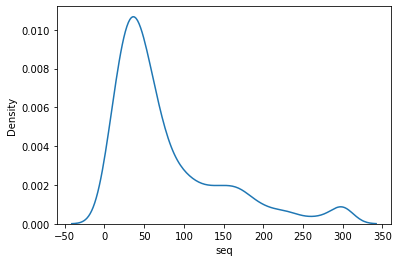

In [74]:
sns.kdeplot(lengths)
# Why negative lenghts? 


In [75]:
len(data.iloc[lengths.argmin()].seq)
# OK no neg length, just smoothing of the curve

1

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [65]:
data['seq'] = data.seq.apply(lambda x: x[:300])

<ipython-input-65-3328a3fbc1eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seq'] = data.seq.apply(lambda x: x[:300])


<AxesSubplot:xlabel='seq', ylabel='Density'>

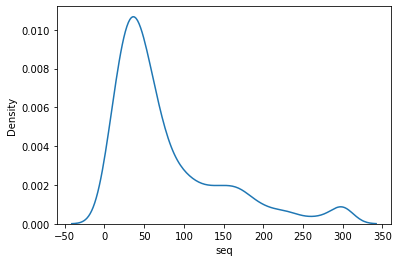

In [66]:

sns.kdeplot(data.seq.apply(len))

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [32]:
from gensim.models import Word2Vec

/Users/admin/.pyenv/versions/3.8.5/envs/deep4deep/envs/general_purpose/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [77]:
word2vec = Word2Vec(sentences=data.seq, window=5, vector_size=100)

In [85]:
word2vec.vector_size

100

In [95]:
def embed_seq(seq):
    embedded_sentence = []
    for word in seq:
        if word in word2vec.wv:  # au cas où X_test ait des nouveaux mots
            vector = word2vec.wv.get_vector(word)  # ou word2vec.wv[word]
            embedded_sentence.append(vector)
    if len(embedded_sentence) == 0: 
    # au cas où tous les mots soient nouveaux!
        embedded_sentence = [np.zeros(word2vec.vector_size)]
    return embedded_sentence # ou np.array(result)

In [97]:
data.loc[:,'embed']= data['seq'].apply(embed_seq)

/Users/admin/.pyenv/versions/3.8.5/envs/deep4deep/envs/general_purpose/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [98]:
data

,artist,verse,preprocessed_verse,seq,embed
0,Drake,"Ayy, woah Ayy, ayy Yeah","Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]","[[0.28398263, 0.83930105, -0.4780515, -0.24111..."
1,Drake,I'm makin' a change today The liquor been taki...,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[0.22425504, -0.20273875, -0.7999428, 0.30299..."
2,Drake,"I can't just be with you and only you Yeah, I ...","I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...","[[0.00035037598, 0.63717, -0.2789135, 0.676622..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...","[[0.10517484, 0.45802763, -0.38076177, 0.22243..."
4,Drake,I'm makin' a change today The liquor been taki...,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[0.22425504, -0.20273875, -0.7999428, 0.30299..."
...,...,...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,...","[[0.012382422, 0.07412076, 0.017790478, 0.0432..."
3971,Kanye West,"Then one day I just went ahead and played it, ...","Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl...","[[-0.026468778, 0.27968934, -0.17910102, 0.086..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]","[[0.00035037598, 0.63717, -0.2789135, 0.676622..."
3973,Kanye West,Like they still weren't looking at me like a r...,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ...","[[0.12370775, 0.25256673, 0.03595994, 0.050488..."


In [99]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [124]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MASK_VALUE = -100

X = pad_sequences(data.embed, dtype='float32', padding='post', 
           value=MASK_VALUE)

# NB: using -100 instead of 0 as pad value to avoid confusion
# NB:   maxlen not necessary as we cropped before already

In [125]:
X.shape

(3040, 299, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [108]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

vec = label_encoder.fit_transform(data['artist'])

vec, label_encoder.classes_

(array([0, 0, 0, ..., 2, 2, 2]),
 array(['Drake', 'Ed Sheeran', 'Kanye West'], dtype=object))

In [110]:
y = to_categorical(vec)

In [116]:
y.shape

(3040, 3)

👉 We train/test split the dataset below for you

In [126]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [127]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

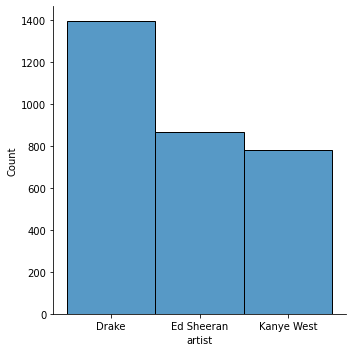

In [177]:
sns.displot(data.artist)




In [155]:
y_train

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [174]:

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')

y_train_dummy = y_train.argmax(axis=1)
y_test_dummy = y_test.argmax(axis=1)

In [175]:
y_train_dummy

array([0, 1, 0, ..., 1, 1, 2])

In [176]:
dummy_clf.fit(X_train, y_train_dummy)

dummy_clf.score(X_test, y_test_dummy)

#dummy_clf.score(X_test, y_test)

0.47368421052631576

In [178]:
score_baseline = dummy_clf.score(X_test, y_test_dummy)
score_baseline

0.47368421052631576

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [145]:
from tensorflow.keras import models, layers

def init_model():
    model = models.Sequential()
    
    # Layer de masking:
    model.add(layers.Masking(mask_value=MASK_VALUE)) 
    
    model.add(layers.LSTM(units=20, activation='tanh'))#, input_shape=(299,100)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

model = init_model()

# The model was terribly overfitting, adding dropout layers


❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [146]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train,
         batch_size=16,
         epochs=500, verbose=2,
         validation_split=0.3,
         callbacks=[es])

Epoch 1/500
107/107 - 26s - loss: 1.0798 - accuracy: 0.4242 - val_loss: 1.0617 - val_accuracy: 0.4548
Epoch 2/500
107/107 - 20s - loss: 1.0728 - accuracy: 0.4548 - val_loss: 1.0557 - val_accuracy: 0.4562
Epoch 3/500
107/107 - 21s - loss: 1.0595 - accuracy: 0.4542 - val_loss: 1.0483 - val_accuracy: 0.4603
Epoch 4/500
107/107 - 20s - loss: 1.0508 - accuracy: 0.4589 - val_loss: 1.0331 - val_accuracy: 0.4630
Epoch 5/500
107/107 - 18s - loss: 1.0312 - accuracy: 0.4818 - val_loss: 1.0219 - val_accuracy: 0.4671
Epoch 6/500
107/107 - 21s - loss: 1.0244 - accuracy: 0.4882 - val_loss: 0.9879 - val_accuracy: 0.5137
Epoch 7/500
107/107 - 18s - loss: 1.0069 - accuracy: 0.5135 - val_loss: 1.0027 - val_accuracy: 0.5027
Epoch 8/500
107/107 - 18s - loss: 0.9833 - accuracy: 0.5253 - val_loss: 0.9807 - val_accuracy: 0.5027
Epoch 9/500
107/107 - 19s - loss: 0.9736 - accuracy: 0.5376 - val_loss: 0.9609 - val_accuracy: 0.5384
Epoch 10/500
107/107 - 27s - loss: 0.9642 - accuracy: 0.5382 - val_loss: 0.9814 - 

❓ **Plot the training and validation losses through training**

In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(13,5))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    if title:
        fig.suptitle(title)

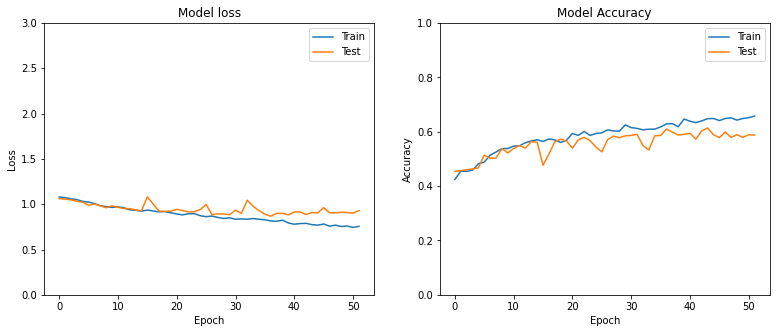

In [147]:
plot_loss_accuracy(history)

In [130]:
# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

<Figure size 432x288 with 0 Axes>

---

## trying to better the model



In [ ]:
from tensorflow.keras import models, layers

# more units in teh LSTM layer

def init_model():
    model = models.Sequential()
    
    # Layer de masking:
    model.add(layers.Masking(mask_value=MASK_VALUE)) 
    
    model.add(layers.LSTM(units=60, activation='tanh'))#, input_shape=(299,100)))
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

model = init_model()


from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train,
         batch_size=8,
         epochs=500, verbose=2,
         validation_split=0.3,
         callbacks=[es])

Epoch 1/500


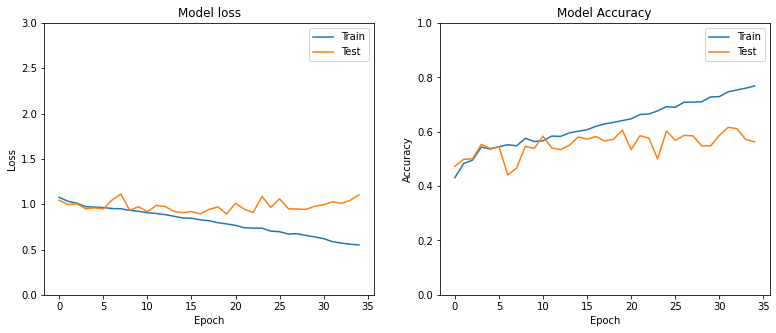

In [182]:
plot_loss_accuracy(history)

❓ **Save your accuracy on test set as `score_test`**

In [40]:
score_test = model.ev()

🧪 **Send your results below**

In [33]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()